# Building an SVM from Scratch - My Version

Based on turotial by sentdex on Mahine Learning with Python.

Lesson here: https://pythonprogramming.net/q-learning-reinforcement-learning-python-tutorial/

Youtube videos here:

https://www.youtube.com/watch?v=AbVtcUBlBok&list=PLQVvvaa0QuDfKTOs3Keq_kaG2P55YRn5v&index=25

In [2]:
#imports
import matplotlib as plt
from matplotlib import style
import numpy as np
style.use('ggplot')

In [4]:
data_dict = {-1:np.array([[1,7],[2,8],[3,8]]),
             1:np.array([[5,1],[6,-1],[7,3]])}

In [8]:
class Support_Vector_Machine:
    def __init__(self, visualization=True):
        self.visualization = visualization
        self.colors = {1:'r', -1:'b'}
        if self.visualization:
            self.fig = plt.figure()
            self.ax = self.fig.add_subplot(1,1,1)
    
    #train
    def fit(self, data):
        #need to figure out w and b
        self.data = data
#         { ||w|| : [w,b]}  
#         create a dictionary where the key is the magnitude of w,
#         and the value for each key is the w and b values.
        
    # for magnitude, the sign doesn't matter, but for each w the sign matters
        transforms = [[1,1], [1,-1], [-1,1], [-1,-1]]  #have to try out each sign of the w values
        
        all_data = [] # get all the values for each feature, store in one list
        for yi in self.data:
            for featureset in self.data[yi]:
                for feature in featureset:
                    all_data.append(feature)
        
        self.max_feature_value = max(all_data)
        self.min_feature_value = min(all_data)
        all_data = None  #clear the all_data list
        
        step_sizes = [self.max_feature_value * 0.1,
                     self.max_feature_value * 0.01,
                     self.max_feature_value * 0.001]  #point of "expense"
        
        # support vectors will be  yi(xi * w + b) = 1
        # when it gets really close to 1 it has been "optimized", although some cannot be optimized
        
        # extremely "expensive" to try out different values for b
        b_range_multiple = 5
        
        # 
        b_multiple = 5
        
        latest_optimum = self.max_feature_value * 10   #this is to save a lot of processing
        
        #stepping process
        for step in step_sizes:
            w = np.array([latest_optimum, latest_optimum])
            
            # we can only do this because the problem is convex
            optimized = False
            
            while not optimized:
                # this could instead have a range of values like used for step_sizee, but takes
                # alot of processing
                for b in np.arange(-1 * (self.max_feature_value * b_range_multiple),
                                   self.max_feature_value * b_range_multiple, step * b_multiple):
                    for transformation in transforms:
                        w_t = w * transformation
                        found_option = True
                        # weakest link, SMO attempts to address this
                        # yi(xi*w+b) >=1  this is the goal each time
                        #
                        # #### could make a break here to save processing
                        for i in self.data:
                            for xi in self.data[i]:  #could call xi "y" instead
                                yi=i
                                if not yi * (np.dot(w_t, xi) + b) >= 1:
                                    found_option = False
                                    
                        if found_option:
                            opt_dict[np.linalg.norm(w_t)] = [w_t, b]
                if w[0] < 0:
                    optimized = True
                    print('Optimized a step')
                else:
                    # w = [5,5]
                    # step = 1
                    # w - step = [4,4]
                    w = w - step
                                
            norms = sorted([n for n in opt_dict])
            opt_choice = opt_dict[norms[0]]
            
            self.w = opt_choice[0]
            self.b = opt_choice[1]
            latest_optimum = opt_choice[0][0]
        
        
    #predict
    def predict(self, features):
        #sign of (x*w+b) determines the classification
        classification = np.sign(np.dot(np.array(features), self.w) + self.b)
        return classification
        

## Introduction

In this lab, you'll program a simple Support Vector Machine from scratch!

## Objectives

You will be able to:
- Build a simple linear max-margin classifier from scratch
- Build a simple soft-margin classifier from scratch


## The Data

Support Vector Machines can be used on problem cases where we have an $n$-dimensional feature space. For teaching purposes, however, we use a 2-dimensional feature space so you can see what exactly is going on when using support vector machines.

Scikit-learn has excellent data sets generator. one of them is `make_blobs`. Below, you can find the code to create two blobs using the `make_blobs` function. We will use this data to build our own SVM from scratch! 

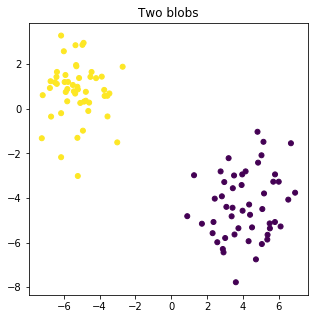

In [1]:
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt
%matplotlib inline  
import numpy as np

plt.figure(figsize=(5, 5))

plt.title("Two blobs")
X, labels = make_blobs(n_features = 2, centers = 2, cluster_std=1.25,  random_state = 123)
plt.scatter(X[:, 0], X[:, 1], c = labels, s=25);

## Building a Max Margin Classifier
Recall from the previous lesson that creating a support vector machine actually boils down to solving a convex optimization problem. You can use the the Python library "cvxpy" to do so, more information can be found [here](http://www.cvxpy.org/).

You may have not used cvxpy before, so make sure it is installed using your terminal and the command `pip install cvxpy`.

The four important commands to be used here are:

- `cp.Variable()` where you either don't include antything between `()` or, if the variable is an array with multiple elements, the number of elements.
- `cp.Minimize()` or `cp.Maximize`, with between the parentheses the element to be maximized.
- `cp.Problem(objective, constraints)`, the objective is generally a stored minimization or maximization objective, the constraints are listed constraints. Constraints can be added by a "+" sign. 
- Next, you should store your `cp.Problem` in an object and use `object.solve()` to solve the optimization problem.

To get more clarity, we strongly recommend to look at the example here. 

Recall that we're trying to solve this problem:

$ w x^{(i)} + b \geq 1$  if $y ^{(i)} = 1$

$ w x^{(i)} + b \leq -1$  if $y ^{(i)} = -1$

And as an objective function we're maximizing $\dfrac{2}{\lVert w \rVert}$. To make things easier, we'll minimizing $\lVert w \rVert$

Note that $y^{(i)}$ is the class label here. Looking at our data the labels are stored in `labels`. Let's have a look at the labels by printing them below.

In [2]:
labels

array([0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1,
       1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1,
       1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1,
       0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1,
       1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0])

In [3]:
X[:5,:]

array([[ 5.06326521, -6.06306418],
       [ 6.10902399, -5.27479172],
       [ 3.42517616, -4.43475028],
       [-7.22783202, -1.31979044],
       [ 5.08871175, -4.4942579 ]])

Before we start to write down the optimization problem, let's split our data in the two classes. Name them `class_1` and `class_2`.

In [4]:
class_1 = X[labels==0]
class_2 = X[labels==1]

Let's find a wat to create a hyperplane (in this case, a line) that can maximize the difference between the two classes. 
- First, `import cvxpy as cp`
- Next, define the variables. note that b and w are variables (what are the dimensions?)
- Then, build the constraints. We have two constraints here
- After that, use "+" to group the constraints togethes
- The next step is to define the objective function
- After that, define the problem using `cp.Problem`
- Solve the problem using `.solve`
- After that, print the problem status (however you defined the problem, and attach `.status`.

In [9]:
!pip list

Package              Version  
-------------------- ---------
absl-py              0.7.0    
appnope              0.1.0    
asn1crypto           0.24.0   
astor                0.7.1    
atomicwrites         1.3.0    
attrs                18.2.0   
backcall             0.1.0    
bleach               1.5.0    
certifi              2019.3.9 
cffi                 1.11.5   
chardet              3.0.4    
convertdate          2.1.3    
cryptography         2.3.1    
cryptography-vectors 2.3.1    
cvxpy                1.0.24   
cycler               0.10.0   
Cython               0.29.7   
decorator            4.3.0    
dill                 0.2.9    
ecos                 2.0.5    
entrypoints          0.3      
ephem                3.7.6.0  
fastcache            1.1.0    
fbprophet            0.5      
future               0.17.1   
gast                 0.2.2    
graphviz             0.10.1   
grpcio               1.18.0   
h5py                 2.9.0    
holidays             0.9.10   
html5lib

In [7]:
import cvxpy as cp 

ModuleNotFoundError: No module named 'cvxpy'

In [ ]:


# Define the variables


# Define the constraints


# Sum the constraints


# Define the objective. Hint: use cp.norm


# Add objective and constraint in the problem


# Solve the problem


Below, we provide you with a helper function to plot your result.

In [ ]:
## Define a helper function for plotting the results, the decision plane, and the supporting planes

def plotBoundaries(x, y, w, b):
    # Takes in a set of datapoints x and y for two clusters,
    d1_min = np.min([x[:,0],y[:,0]])
    d1_max = np.max([x[:,0],y[:,0]])
    # Line form: (-a[0] * x - b ) / a[1]
    d2_at_mind1 = (-w[0]*d1_min - b ) / w[1]
    d2_at_maxd1 = (-w[0]*d1_max - b ) / w[1]
    sup_up_at_mind1 = (-w[0]*d1_min - b + 1 ) / w[1]
    sup_up_at_maxd1 = (-w[0]*d1_max - b + 1 ) / w[1]
    sup_dn_at_mind1 = (-w[0]*d1_min - b - 1 ) / w[1]
    sup_dn_at_maxd1 = (-w[0]*d1_max - b - 1 ) / w[1]

    # Plot the clusters!
    plt.scatter(x[:,0],x[:,1],color='purple')
    plt.scatter(y[:,0],y[:,1],color='yellow')
    plt.plot([d1_min,d1_max],[d2_at_mind1 ,d2_at_maxd1],color='black')
    plt.plot([d1_min,d1_max],[sup_up_at_mind1,sup_up_at_maxd1],'-.',color='blue')
    plt.plot([d1_min,d1_max],[sup_dn_at_mind1,sup_dn_at_maxd1],'-.',color='blue')
    plt.ylim([np.floor(np.min([x[:,1],y[:,1]])),np.ceil(np.max([x[:,1],y[:,1]]))])

Now use the helper function to plot your result. To get the values of `w` and `b`. use the two variables with `.value`. The two first arguments should be the two classes, `class_1` and `class_2`.

## A more complex problem

Let's look at another problem by running the code below. It's clear that now, the two classes are not perfectly linearly separable.

In [ ]:
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt
%matplotlib inline  
import numpy as np

plt.figure(figsize=(5, 5))

plt.title("Two blobs")
X, labels = make_blobs(n_features = 2, centers = 2, cluster_std=3,  random_state = 123)
plt.scatter(X[:, 0], X[:, 1], c = labels, s=25);

Copy your optimization code from the Max Margin Classifier and look at the problem status. What do you see?

In [ ]:
# copy the optimization code

### Explain what's happening

The problem status is "infeasible": the problem is not linearly separable, in other words, we cannot draw one straight line that separates the two classes.

## Building a Soft Margin Classifier

To solve this problem, you'll need to "relax" your constraints and allow for items that are not correctly classified. This is where the Soft Margin Classifier comes in! As a refresher, this is the formulation for the Soft Margin Classifier:

$$ b + w_Tx^{(i)} \geq 1-\xi^{(i)}  \text{     if     } y ^{(i)} = 1$$

$$ b + w_Tx^{(i)} \leq -1+\xi^{(i)}  \text{     if     } y ^{(i)} = -1$$


The objective function is 

 $$\dfrac{1}{2}\lVert w \rVert^2+ C(\sum_i \xi^{(i)})$$
 
 We created the new data set again below. Let's use the code for the SVM optimization again, but adjust for the slack parameters $\xi$ (ksi or xi).
 
Some important things to note:
- Every $\xi$ needs to be positive, that should be added as constraints
- Your objective needs to be changed as well
- Allow for a "hyperparameter" C which you set to 1 at first and you can change accordingly. Describe how your result changes.


In [ ]:
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt
%matplotlib inline  
import numpy as np

plt.figure(figsize=(5, 5))

plt.title("Two blobs")
X, labels = make_blobs(n_features = 2, centers = 2, cluster_std=3,  random_state = 123)
plt.scatter(X[:, 0], X[:, 1], c = labels, s=25);

In [ ]:
#reassign the class labels


In [ ]:

# Define the variables


# Define the constraints





# Sum the constraints

# Define the objective. Hint: use cp.norm. Add in a C hyperparameter and assume 1 at first


# Add objective and constraint in the problem


# Solve the problem



Plot your result again

In [ ]:
# your code here

Now go ahead and experiment with the hyperparameter C (making it both larger and smaller than 1). What do you see?

## Summary

Great! You now understand the rationale behind support vector machines. Wouldn't it be great to have a library that did this for you? Well, you're lucky: scikit-learn has an SVM-module which automizes all of this. In the next lab, you'll learn how to use this scikit-learn module!